# Gradient Descent

решение уравнений методом вариаций и градиентного спуска

In [1]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import physics as ph
from Sun import SSM18 as s

Physics version 1.11 10.07.2020
SSM18 version 1.7 4.07.2020


In [3]:
pi = math.pi
Z = s.Z

In [4]:
def load_model(epoch):
    filename = 'Mass/3epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.451000e+07,90.073858,0.000000e+00,0.732,1.445415,1.0,1.794120e+17,1.208753e-10
1,1,1.990588e+30,1.744864e+09,1.439966e+07,89.041127,3.337100e+31,0.732,1.461410,0.0,1.760063e+17,1.149243e-10
2,2,3.981176e+30,2.201408e+09,1.433513e+07,88.430509,6.557975e+31,0.732,1.470834,0.0,1.740159e+17,1.115997e-10
3,3,5.971765e+30,2.522902e+09,1.428116e+07,87.917179,9.694220e+31,0.732,1.478767,0.0,1.723544e+17,1.089033e-10
4,4,7.962353e+30,2.779701e+09,1.423310e+07,87.458197,1.275919e+32,0.732,1.485871,0.0,1.708776e+17,1.065640e-10
...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.982626e+33,4.139110e+10,9.072824e+05,0.203440,3.562824e+33,0.732,1.486150,0.0,2.533749e+13,1.087433e-21
997,997,1.984616e+33,4.188541e+10,8.016714e+05,0.166783,3.562824e+33,0.732,1.191579,0.0,1.835411e+13,2.401102e-22
998,998,1.986607e+33,4.249698e+10,6.818832e+05,0.125189,3.562824e+33,0.732,0.907523,0.0,1.171825e+13,3.241820e-23
999,999,1.988598e+33,4.336443e+10,5.328578e+05,0.075302,3.562824e+33,0.732,0.639191,0.0,5.508131e+12,1.428180e-24


In [5]:
x = df['Hydrogen'].values
m = df['Mass'].values
d = df['Density'].values
t = df['Temperature'].values
# v = df['Velocity'].values

In [6]:
r = np.zeros(dimM)
l = np.zeros(dimM)
p = np.zeros(dimM)
k = np.zeros(dimM)
v = np.zeros(dimM)

In [7]:
d1 = d.copy()
t1 = t.copy()
x1 = x.copy()
# Вычисляем величины r,l,p,k,c,v из x,m,d,t
r[0] = 0.
l[0] = 0.
for i in range(1, dimM):
    r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
for i in range(dimM):
    X = x1[i]
    Y = 1 - Z -X
    p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
    k[i] = ph.Opacity(d1[i], t1[i], X, Y, Z)
    v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year

In [8]:
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

In [9]:
N = 40 #
M = 25
print('N*M+1 = dimM is '+ str(N*M+1 == dimM))

N*M+1 = dimM is True


In [10]:
def Error():
    # Вычисляем величины r,l,p,k,c,v из x1,m,d1,t1
    r[0] = 0.
    l[0] = 0.
    for i in range(1, dimM):
        r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
        l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
    for i in range(dimM):
        X = x1[i]
        Y = 1 - Z - X
        p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
        k[i] = ph.Opacity(d1[i], t1[i], X, Y, Z)
        v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year
    sa = 0
    sb = 0
    for i in range(1, dimM-1):
        X = x1[i]
        Y = 1 - Z - X
        mu = ph.MU(X, Y, Z)
        a[i] = -ph.G*m[i]*d1[i]/pow(r[i], 2)
        da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1])
        br[i] = -3/16*k[i]*d1[i]*l[i]/ph.sigma/pow(t1[i], 3)/4/pi/pow(r[i], 2)
        bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
        if abs(br[i]) < abs(bc[i]):
            b[i] = br[i]
        else:
            b[i] = bc[i]
        db[i] = (t1[i+1] - t1[i])/2/(r[i+1] - r[i]) + (t1[i] - t1[i-1])/2/(r[i] - r[i-1])
        sa += pow((da[i] - a[i])/6760886, 2)
        sb += pow((db[i] - b[i])/0.000324, 2)
#     print(sa, sb)
    return (sa*3 + sb)/0.09726621893099568

In [11]:
def factor(i, j):
    n = abs(i - j*M)
    if n >= M:
        return 0.
    if j == 0:
        return 2.*(1. - i/M)
    return 1. - n/M

In [54]:
NG = 300 
err = np.zeros(NG)
count = 0
k0 = 0.0001
ed = np.zeros(N+1)
et = np.zeros(N+1)
x1 = df['Hydrogen'].values.copy()
d1 = df['Density'].values.copy()
t1 = df['Temperature'].values.copy()
v = df['Velocity'].values.copy()
# x1 = x1*np.exp(-1e9*v)

In [55]:
count = 0
err[count] = Error()
err[count]

3.8390049627746827

In [19]:
%%time
while count < NG:
    
    d2 = d1.copy()
    t2 = t1.copy()
    
    for j in range(N+1):
        for i in range(dimM):
            d1[i] = d2[i] + 0.001*factor(i, j)*d2[i]
        ed[j] = Error() - err[count]
    
    d1 = d2.copy()
    for j in range(N+1):
        for i in range(dimM):
            t1[i] = t2[i] + 0.001*factor(i, j)*t2[i]
        et[j] = Error() - err[count]   
#     print(ed, et)
    stepd = pow((ed*ed).sum(), 0.5)
    stept = pow((et*et).sum(), 0.5)
    cosd = 1.
    cost = 1.
    if (count > 0):
        cosd = (ed*ed2).sum()/stepd/stepd2
        cost = (et*et2).sum()/stept/stept2
    stepd2 = stepd
    stept2 = stept
    ed2 = ed.copy()
    et2 = et.copy()
    d1 = d2.copy()
    t1 = t2.copy()
    for i in range(dimM):
        for j in range(N+1):
            f = factor(i, j)
            d1[i] -= k0*f*ed[j]*d2[i]
            t1[i] -= k0*f*et[j]*t2[i]
    err0 = err[count]
    count += 1
    err1 = Error()
    
    err[count] = err1
    print('count=%d Error=%.2f Ratio=%.3f stepd=%.2f cosd=%.5f stept=%.2f cost=%.5f' % (count, err[count], 100*err0/err1 - 100., stepd, cosd, stept, cost))
    if err0 <= err1:
        break

count=1 Error=315.66 Ratio=2.745 stepd=5.21 cosd=1.00000 stept=12.29 cost=1.00000
count=2 Error=307.82 Ratio=2.546 stepd=5.00 cosd=0.99869 stept=12.01 cost=0.99892
count=3 Error=300.67 Ratio=2.378 stepd=4.83 cosd=0.99932 stept=11.76 cost=0.99938
count=4 Error=294.11 Ratio=2.231 stepd=4.67 cosd=0.99948 stept=11.54 cost=0.99951
count=5 Error=288.06 Ratio=2.100 stepd=4.53 cosd=0.99957 stept=11.35 cost=0.99958
count=6 Error=282.46 Ratio=1.983 stepd=4.41 cosd=0.99963 stept=11.14 cost=0.99946
count=7 Error=277.05 Ratio=1.954 stepd=4.29 cosd=0.99962 stept=10.98 cost=0.99966
count=8 Error=272.20 Ratio=1.780 stepd=4.19 cosd=0.99971 stept=10.86 cost=0.99950
count=9 Error=267.67 Ratio=1.691 stepd=4.09 cosd=0.99975 stept=10.73 cost=0.99974
count=10 Error=263.43 Ratio=1.610 stepd=4.00 cosd=0.99979 stept=10.60 cost=0.99979
count=11 Error=259.45 Ratio=1.535 stepd=3.92 cosd=0.99981 stept=10.48 cost=0.99981
count=12 Error=255.70 Ratio=1.465 stepd=3.84 cosd=0.99983 stept=10.37 cost=0.99983
count=13 Erro

count=101 Error=179.91 Ratio=0.010 stepd=2.17 cosd=0.99999 stept=7.61 cost=1.00000
count=102 Error=179.90 Ratio=0.006 stepd=2.17 cosd=0.99999 stept=7.60 cost=1.00000
count=103 Error=179.80 Ratio=0.058 stepd=2.16 cosd=0.99999 stept=7.59 cost=1.00000
count=104 Error=179.80 Ratio=-0.003 stepd=2.16 cosd=0.99999 stept=7.61 cost=0.99982
Wall time: 14min 18s


In [20]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t1, 'Density': d1, 
          'Luminosity': l, 'Hydrogen': x1, 'Opacity': k, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.457816e+07,92.963855,0.000000e+00,0.648658,1.409733,1.743628e+17,1.144753e-10
1,1.990588e+30,1.722634e+09,1.446386e+07,91.834121,2.841390e+31,0.652529,1.427761,1.714251e+17,1.090339e-10
2,3.981176e+30,2.174823e+09,1.439562e+07,91.140962,5.580435e+31,0.654702,1.438408,1.696232e+17,1.059074e-10
3,5.971765e+30,2.493353e+09,1.433801e+07,90.548923,8.253486e+31,0.656470,1.447375,1.680841e+17,1.033405e-10
4,7.962353e+30,2.747883e+09,1.428636e+07,90.013596,1.087080e+32,0.658008,1.455408,1.666929e+17,1.010943e-10
...,...,...,...,...,...,...,...,...,...
996,1.982626e+33,4.116824e+10,9.069337e+05,0.203452,3.093984e+33,0.732000,1.485823,2.532923e+13,1.083063e-21
997,1.984616e+33,4.162260e+10,8.013588e+05,0.166791,3.093984e+33,0.732000,1.191321,1.834786e+13,2.391285e-22
998,1.986607e+33,4.216373e+10,6.816135e+05,0.125195,3.093984e+33,0.732000,0.907347,1.171410e+13,3.228361e-23
999,1.988598e+33,4.286377e+10,5.326440e+05,0.075305,3.093984e+33,0.732000,0.639104,5.506101e+12,1.422153e-24


In [21]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/3epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/3epoch01.csv


In [22]:
epoch = 0
df = load_model(epoch)
d = df['Density'].values
t = df['Temperature'].values
d

array([9.00738577e+01, 8.90411272e+01, 8.84305086e+01, ...,
       1.25189351e-01, 7.53021785e-02, 2.09797553e-05])

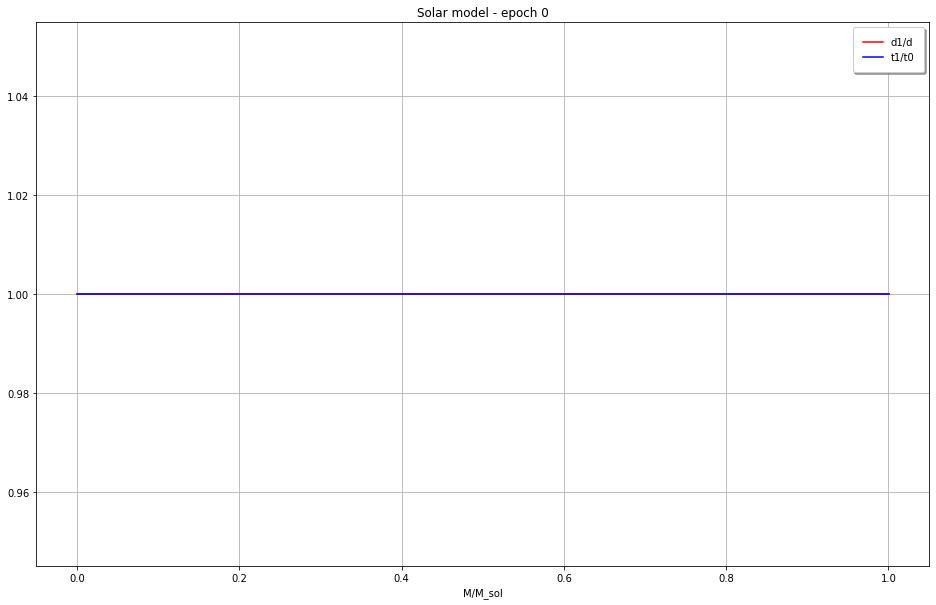

In [39]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [56]:
ea = np.zeros(dimM)
eb = np.zeros(dimM)
for i in range(1, dimM-1):
    ea[i] = 3*pow((da[i] - a[i])/6760886, 2)
    eb[i] = pow((db[i] - b[i])/0.000324, 2)
sa = ea.sum()
sb = eb.sum()
etot = (sa + sb)/0.09726621893099568

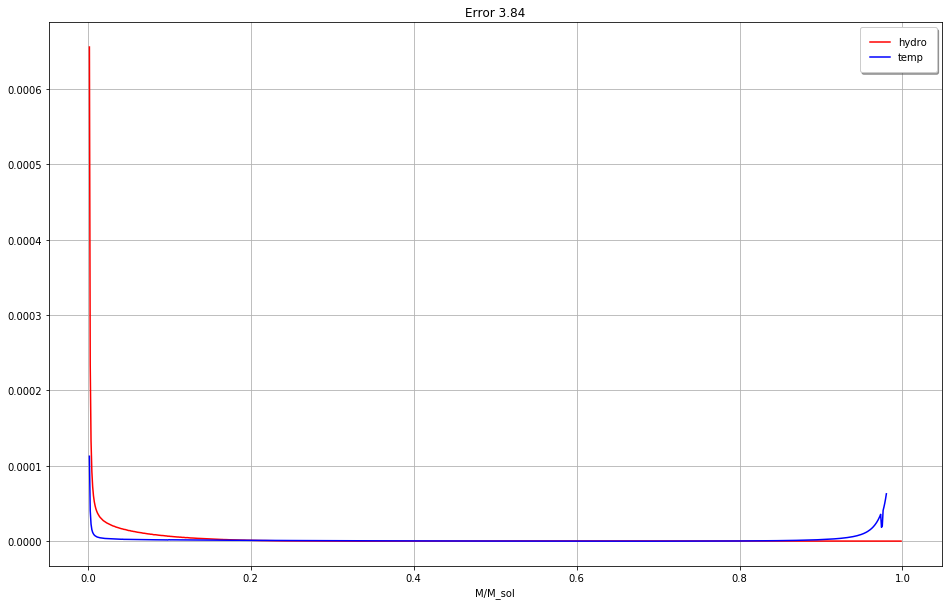

In [59]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1[2:-2], ea[2:-2], color='red', label='hydro')
plt.plot(m1[2:-20], eb[2:-20], color='blue', label='temp')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Error %.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);